In [ ]:
#import the needed libraries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

# Solving Puzzle

In this problem, we want to use image processing to help us automatically solve a jigsaw puzzle. Since we know that the completed puzzle should show a picture of the famous Mona Lisa painting, we can download an image of the painting from the web to use as a reference when solving the puzzle. Note that when the puzzle pieces are assembled together, the completed puzzle has the same aspect ratio as but potentially a different area than the reference image.

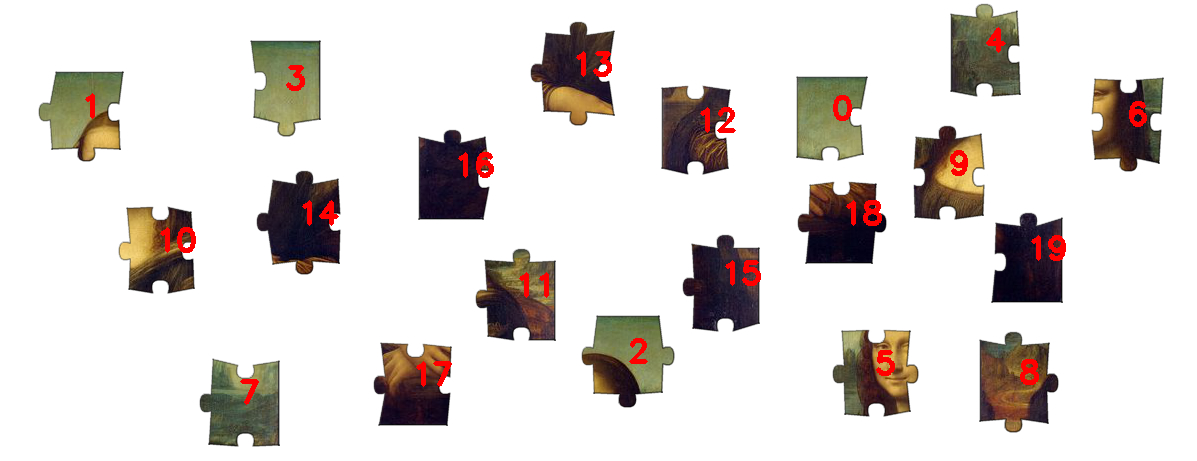

In [ ]:
def solve_puzzle(puzzle_pieces, puzzle_completed):
  #Read images
  puzzle_pieces = cv2.imread(puzzle_pieces)
  puzzle_completed = cv2.imread(puzzle_completed)
  #Convert to grayscale
  gray_puzzle_pieces = cv2.cvtColor(puzzle_pieces, cv2.COLOR_BGR2GRAY)
  gray_puzzle_reference = cv2.cvtColor(puzzle_completed, cv2.COLOR_BGR2GRAY)

  #Create a SIFT Detector to detect keypoints and descriptors
  sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.01)

  #Divide the image into a 20 pieces grid
  h, w = gray_puzzle_reference.shape[:2]
  rows, colums = 5, 4
  grid_h, grid_w = h // rows, w // colums
  grid_cells = []

  #Create lists to store the keypoints and descriptors for each region
  grid_descriptors = []  # To store descriptors of each grid region
  grid_keypoints = []  # To store keypoints of each grid region
  region_positions = []  # To store the coordinates of each grid region

  #create a copy of the image for drawing
  puzzle_with_grid = puzzle_completed.copy()

  for i in range(rows):
    for j in range(colums):
      x_start, y_start = j * grid_w, i * grid_h
      x_end, y_end = x_start + grid_w, y_start + grid_h
      #Save the grid
      grid_cells.append((x_start, y_start, x_end, y_end, gray_puzzle_reference[y_start:y_end, x_start:x_end]))
      region = gray_puzzle_reference[y_start:y_end, x_start:x_end]  # Crop the region from the image

      #Calculate keypoints and descriptors for the cropped region using SIFT
      kp_region, des_region = sift.detectAndCompute(region, None)  # Extract keypoints and descriptors for the region
      grid_keypoints.append(kp_region)  #Append the keypoints of this region
      grid_descriptors.append(des_region)  #Append the descriptors of this region
      region_positions.append((x_start, y_start, x_end, y_end))  #Append the coordinates of the region

    #Step 2: Extract puzzle pieces based on contours
  puzzle_with_labels = puzzle_pieces.copy()  # Copy the puzzle pieces image to draw labels on later

  #Loop through each contour in the list of contours
  for i, contour in enumerate(contours):
      #Step 2.1: Extract the puzzle piece using boundingRect
      x, y, w, h = cv2.boundingRect(contour)  # Get the bounding box coordinates of the contour
      piece = gray_puzzle_pieces[y:y+h, x:x+w]  # Crop the piece using the bounding box coordinates


      #Step 3: Calculate keypoints and descriptors for the extracted puzzle piece
      kp_piece, des_piece = sift.detectAndCompute(piece, None)  # Extract keypoints and descriptors for the piece
      if des_piece is None:
          continue  # Skip if no descriptors are found for the piece

      #Show the keypoints on the puzzle piece for visualization
      piece_with_kps = cv2.drawKeypoints(piece, kp_piece, None, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

      #Step 4: Feature matching - Compare the puzzle piece with each grid region
      best_match_count = 0  # Initialize the best match count
      best_region_idx = -1  # Initialize the index of the best matching grid region
      best_matches = []  # To store the best matches found

      #Loop through each region descriptor in the grid
      for idx, des_region in enumerate(grid_descriptors):
          if des_region is None:
              continue  #Skip if the region has no descriptors

          bf = cv2.BFMatcher()  #Create a brute-force matcher for matching descriptors
          matches = bf.knnMatch(des_piece, des_region, k=2)  #Perform knnMatch to find the best 2 matches for each descriptor

          #Apply Lowe's ratio test to filter out poor matches and keep good ones
          good_matches = []  #To store the good matches
          for m, n in matches:
              if m.distance < 0.5 * n.distance:  #If the first match is significantly better than the second one
                  good_matches.append(m)  #Keep the good match

          #If this region has more good matches, update the best match
          if len(good_matches) > best_match_count:
              best_match_count = len(good_matches)  #Update the best match count
              best_region_idx = idx  #Update the index of the best matching region
              best_matches = good_matches  #Store the best matches

      #Show the matches between the puzzle piece and the best matching grid region
      if best_region_idx != -1:
          #Get the coordinates of the best matching grid region
          x_start, y_start, x_end, y_end = region_positions[best_region_idx]

          #Draw the matches between the piece and the best matching region on the image
          img_matches = cv2.drawMatches(piece, kp_piece, gray_puzzle_reference[y_start:y_end, x_start:x_end],
                                        grid_keypoints[best_region_idx], best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


      #Step 5: Draw the label of the puzzle piece on its position in the grid
      if best_region_idx != -1:
          #Draw the label (index of the grid region) on the puzzle image at the piece's position
          cv2.putText(puzzle_with_labels, str(best_region_idx), (x + w // 2, y + h // 2),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)  # Draw label with red color and thicker text

  #Show the final puzzle with labeled pieces
  cv2_imshow(puzzle_with_labels)

  return puzzle_with_labels

solved_puzzle = solve_puzzle('/content/hw5_puzzle_pieces.jpg', '/content/hw5_puzzle_reference.jpg')


## Broken down

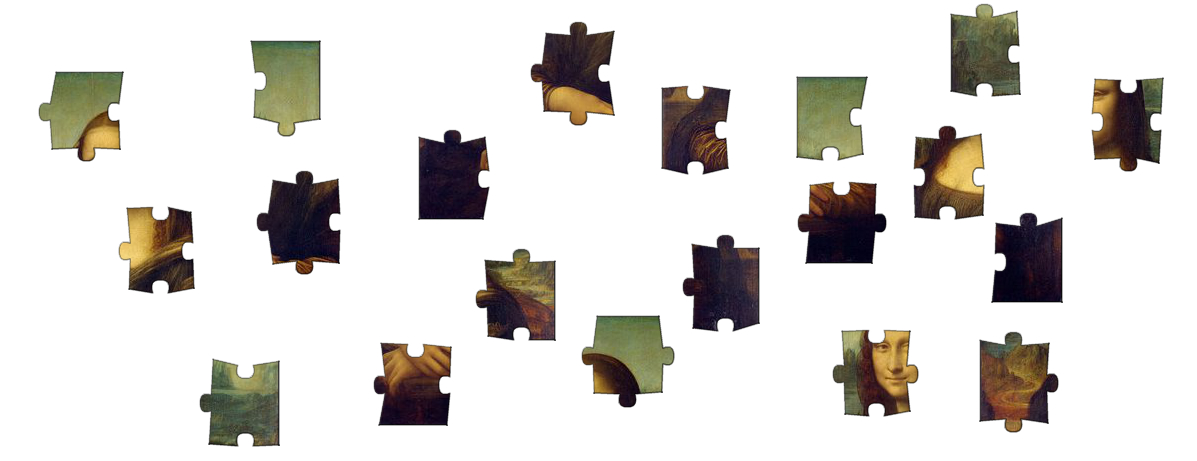

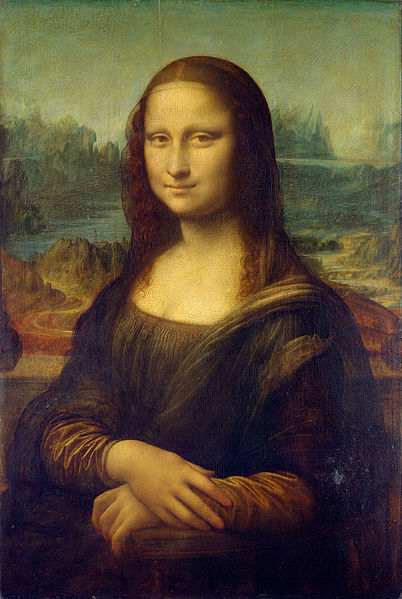

In [ ]:
#Load the image
puzzle_pieces = cv2.imread('/content/hw5_puzzle_pieces.jpg')
puzzle_completed = cv2.imread('/content/hw5_puzzle_reference.jpg')

#Show images
cv2_imshow(puzzle_pieces)
cv2_imshow(puzzle_completed)

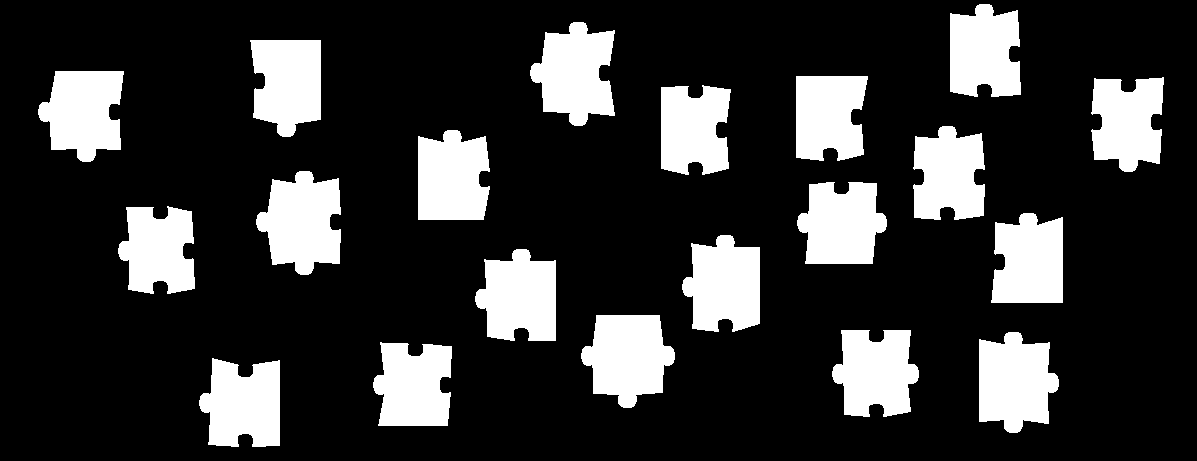

In [ ]:
#Convert to grayscale
gray_puzzle_pieces = cv2.cvtColor(puzzle_pieces, cv2.COLOR_BGR2GRAY)
gray_puzzle_reference = cv2.cvtColor(puzzle_completed, cv2.COLOR_BGR2GRAY)

#Separate the jigsaw piece from the background by applying a threshold
_, thresh_puzzle = cv2.threshold(gray_puzzle_pieces, 230, 255, cv2.THRESH_BINARY_INV)

#Show the puzzle pieces image
cv2_imshow(thresh_puzzle)

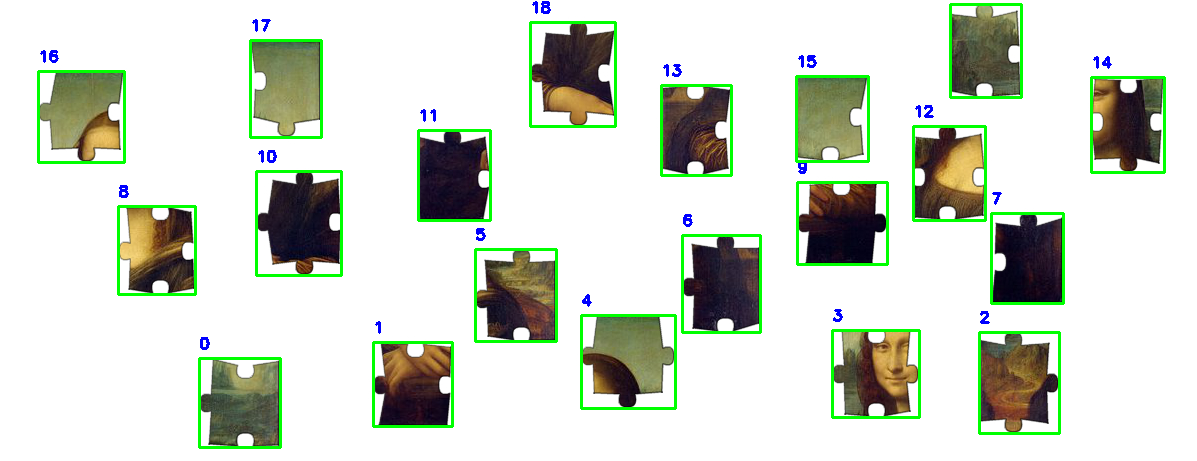

In [ ]:
#Find contours
contours, _ = cv2.findContours(thresh_puzzle, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Loop through contours and label them
pieces = []
piece_bounding_boxes = []
separate_pieces = puzzle_pieces.copy()
for i, contour in enumerate(contours):
#Get bounding box and draw it
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(separate_pieces, (x, y), (x + w, y + h), (0, 255, 0), 2)
    piece = puzzle_pieces[y:y+h, x:x+w]
    pieces.append(piece)
    piece_bounding_boxes.append((x, y, w, h))

    #Label the piece
    cv2.putText(separate_pieces, str(i), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


#Show pieces
cv2_imshow(separate_pieces)

We divide the image into a 4 x 5 grid to simplify the matching process and match each area with the puzzle piece.

In [ ]:
#Let's retry with SIFT
# Create a SIFT Detector to detect keypoints and descriptors
sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.01)

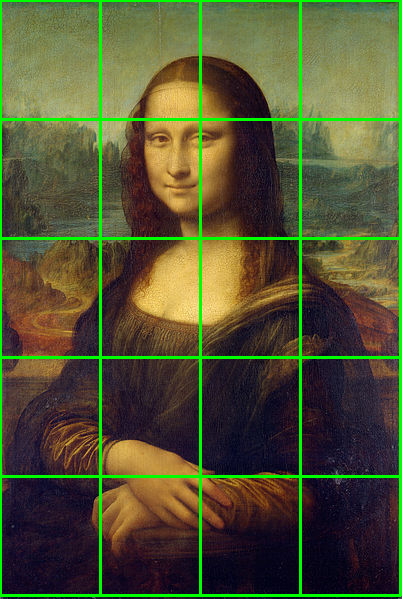

In [ ]:
#Divide the image into a 20 pieces grid
h, w = gray_puzzle_reference.shape[:2]
rows, colums = 5, 4
grid_h, grid_w = h // rows, w // colums
grid_cells = []

#Create lists to store the keypoints and descriptors for each region
grid_descriptors = []  # To store descriptors of each grid region
grid_keypoints = []  # To store keypoints of each grid region
region_positions = []  # To store the coordinates of each grid region

#create a copy of the image for drawing
puzzle_with_grid = puzzle_completed.copy()

for i in range(rows):
  for j in range(colums):
    x_start, y_start = j * grid_w, i * grid_h
    x_end, y_end = x_start + grid_w, y_start + grid_h
    #Save the grid
    grid_cells.append((x_start, y_start, x_end, y_end, gray_puzzle_reference[y_start:y_end, x_start:x_end]))
    region = gray_puzzle_reference[y_start:y_end, x_start:x_end]  # Crop the region from the image

    #Calculate keypoints and descriptors for the cropped region using SIFT
    kp_region, des_region = sift.detectAndCompute(region, None)  # Extract keypoints and descriptors for the region
    grid_keypoints.append(kp_region)  #Append the keypoints of this region
    grid_descriptors.append(des_region)  #Append the descriptors of this region
    region_positions.append((x_start, y_start, x_end, y_end))  #Append the coordinates of the region

    #Draw the rectangles on the image
    cv2.rectangle(puzzle_with_grid, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

#Show the grid
cv2_imshow(puzzle_with_grid)

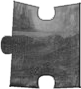

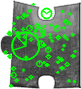

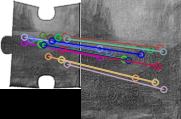

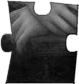

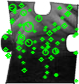

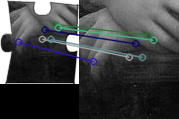

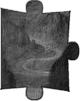

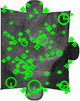

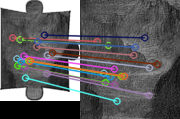

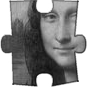

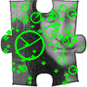

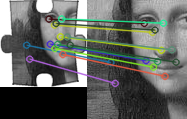

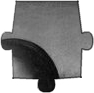

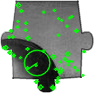

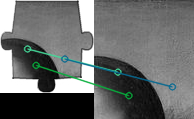

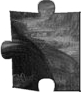

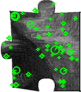

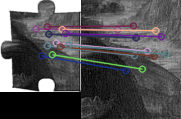

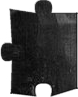

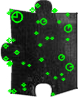

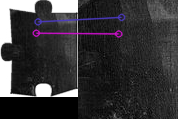

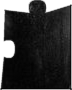

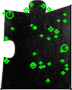

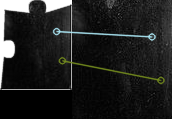

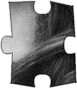

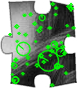

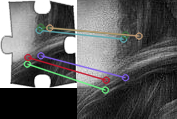

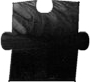

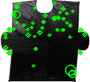

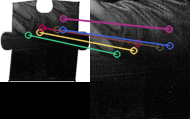

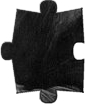

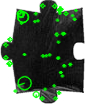

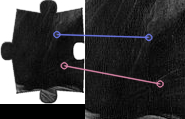

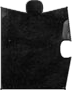

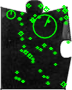

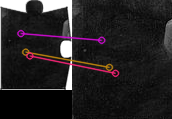

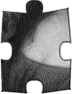

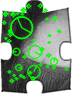

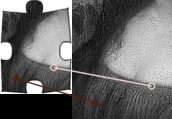

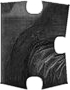

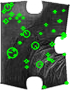

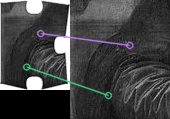

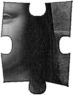

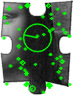

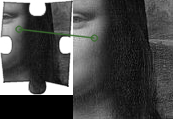

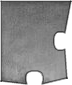

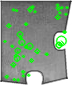

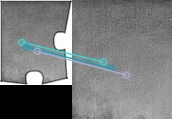

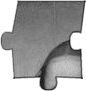

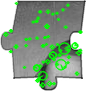

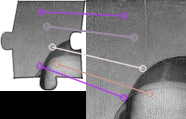

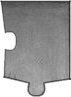

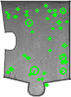

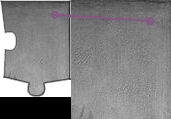

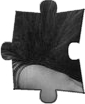

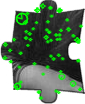

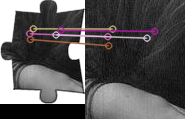

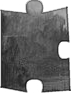

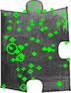

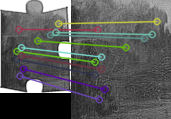

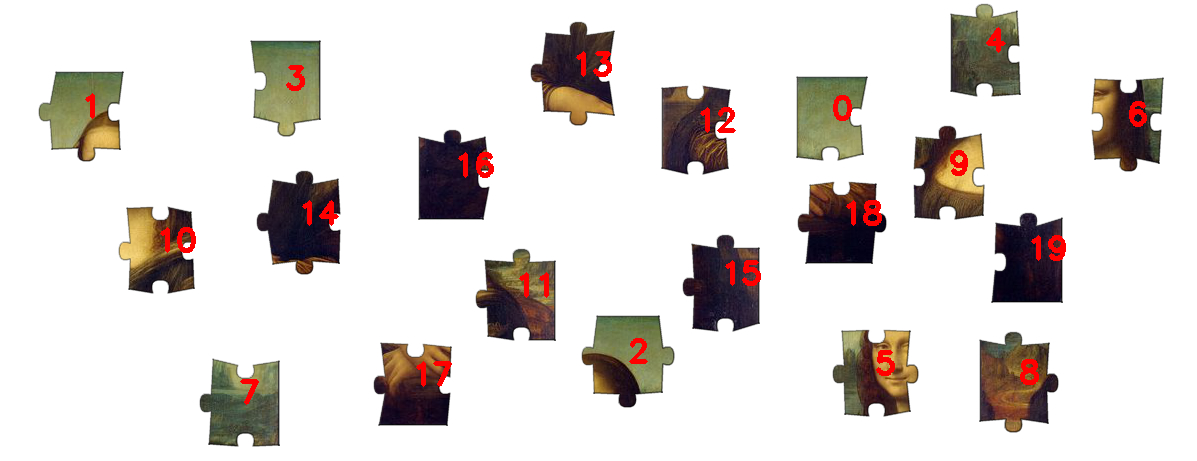

In [ ]:
#Step 2: Extract puzzle pieces based on contours
puzzle_with_labels = puzzle_pieces.copy()  # Copy the puzzle pieces image to draw labels on later

#Loop through each contour in the list of contours
for i, contour in enumerate(contours):
    #Step 2.1: Extract the puzzle piece using boundingRect
    x, y, w, h = cv2.boundingRect(contour)  # Get the bounding box coordinates of the contour
    piece = gray_puzzle_pieces[y:y+h, x:x+w]  # Crop the piece using the bounding box coordinates

    #Show the extracted piece
    cv2_imshow(piece)

    #Step 3: Calculate keypoints and descriptors for the extracted puzzle piece
    kp_piece, des_piece = sift.detectAndCompute(piece, None)  # Extract keypoints and descriptors for the piece
    if des_piece is None:
        continue  # Skip if no descriptors are found for the piece

    #Show the keypoints on the puzzle piece for visualization
    piece_with_kps = cv2.drawKeypoints(piece, kp_piece, None, (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2_imshow(piece_with_kps)

    #Step 4: Feature matching - Compare the puzzle piece with each grid region
    best_match_count = 0  # Initialize the best match count
    best_region_idx = -1  # Initialize the index of the best matching grid region
    best_matches = []  # To store the best matches found

    #Loop through each region descriptor in the grid
    for idx, des_region in enumerate(grid_descriptors):
        if des_region is None:
            continue  #Skip if the region has no descriptors

        bf = cv2.BFMatcher()  #Create a brute-force matcher for matching descriptors
        matches = bf.knnMatch(des_piece, des_region, k=2)  #Perform knnMatch to find the best 2 matches for each descriptor

        #Apply Lowe's ratio test to filter out poor matches and keep good ones
        good_matches = []  #To store the good matches
        for m, n in matches:
            if m.distance < 0.5 * n.distance:  #If the first match is significantly better than the second one
                good_matches.append(m)  #Keep the good match

        #If this region has more good matches, update the best match
        if len(good_matches) > best_match_count:
            best_match_count = len(good_matches)  #Update the best match count
            best_region_idx = idx  #Update the index of the best matching region
            best_matches = good_matches  #Store the best matches

    #Show the matches between the puzzle piece and the best matching grid region
    if best_region_idx != -1:
        #Get the coordinates of the best matching grid region
        x_start, y_start, x_end, y_end = region_positions[best_region_idx]

        #Draw the matches between the piece and the best matching region on the image
        img_matches = cv2.drawMatches(piece, kp_piece, gray_puzzle_reference[y_start:y_end, x_start:x_end],
                                      grid_keypoints[best_region_idx], best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        #Show the matches
        cv2_imshow(img_matches)

    #Step 5: Draw the label of the puzzle piece on its position in the grid
    if best_region_idx != -1:
        #Draw the label (index of the grid region) on the puzzle image at the piece's position
        cv2.putText(puzzle_with_labels, str(best_region_idx), (x + w // 2, y + h // 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)  # Draw label with red color and thicker text

#Show the final puzzle with labeled pieces
cv2_imshow(puzzle_with_labels)
